# Using timeseries forcasting to predict biomarker trends and health outcomes of the monkeys
- Test different time series forcasters (ARIMA, Prophet, or standard catBoost ML) to see if the biomarker and health outcomes of the monkeys can be forecasted on a timeline – very powerful
- If I feel like playing god, I'll also try to forcast death
- It would be great if I can use CatBoost to do the predictions so as to cnsolidate the models in a future iteration, but I'll try all three for accuracy
- I will consider immense success being a model that can forcast a biokarker trend with <25% confidence interval 30 days out, and a model that can forcast a health outcome occuring within 5 days of acctually occuring.
- I will backtest the models with the 20% most recent data
    - and then forcast to the unknown future of the data and validate with the most recent measurments I do not have
    


Article thing with the skforcast: https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

timeseries & catboost examples: https://stackoverflow.com/questions/45262500/example-how-to-use-catboost-with-the-time-series-data

Medium article using catboost for timeseries (no code) https://medium.com/artefact-engineering-and-data-science/time-series-forecasting-how-did-we-put-our-first-sales-forecasting-solution-for-croissants-into-93f9ed45bb49


In [11]:
from os import chdir as cd
cd("/Users/aidanlew/Documents")


In [12]:
### Using monkey_env/ ###

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx



print("Setup Complete")


Setup Complete



# Data setup
Unlike the previous predictions, I want to maintain the timeseries information here

Probably easier to start with the bio data since it is all one one timeline, the health data is on multiple timelines

In [15]:
#Makee a df for the blood analytic data
for_bio_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )
for_bio_df.tail(2)


Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4550,2210,Rhesus-Indian,2021-09-20,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [16]:
for_bio_df['SAMPLE_DATE'] = pd.to_datetime(for_bio_df['SAMPLE_DATE'], format='%Y-%m-%d %H:%M:%S')
for_bio_df = for_bio_df.sort_index()
for_bio_df.head(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,2017-12-20,No,NaT,2007-05-14,F,Clinical,NaN,NaN,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,2018-01-29,No,NaT,2007-05-14,F,Research,NaN,NaN,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


In [17]:
# Make a df of a single monkey's blood analytic data
single_bio_df = for_bio_df.copy()

single_bio_df = single_bio_df[single_bio_df['ID'] == 2046]

single_bio_df['SAMPLE_DATE'] = pd.to_datetime(single_bio_df['SAMPLE_DATE'], format='%Y-%m-%d %H:%M:%S')
single_bio_df = single_bio_df.sort_index()

single_bio_df.tail(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
49,2046,Rhesus-Chinese,2021-04-22,Yes,2014-04-09,2007-07-03,F,Clinical,2570.0,84.0,...,58.3,4.3,0.2,0.3,3247,5130,378,18,26,306
50,2046,Rhesus-Chinese,2021-10-07,Yes,2014-04-09,2007-07-03,F,Research,2738.0,90.0,...,52.8,0.9,0.3,0.1,3387,3897,66,22,7,255


# Visualization

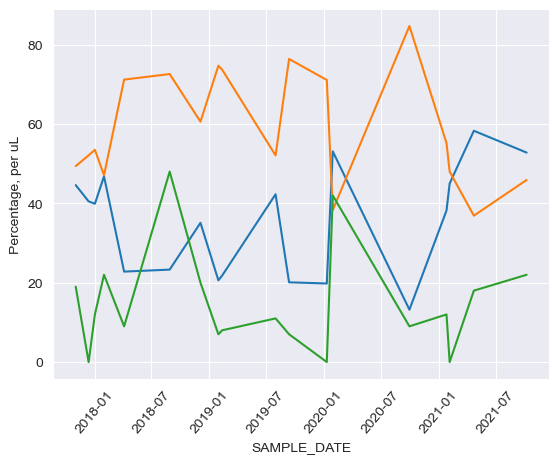

In [18]:
# Viz of a single monkey's lymphocytes, neutrophils, and absolute eosophils over time
sns.lineplot(data = single_bio_df, x = "SAMPLE_DATE", y = "LYMPHOCYTES_(%)")
sns.lineplot(data = single_bio_df, x = "SAMPLE_DATE", y = "NEUT_(%)")
sns.lineplot(data = single_bio_df, x = "SAMPLE_DATE", y = "ABS_EOS_(/uL)")
plt.ylabel("Percentage, per uL")
plt.xticks(rotation = 50);

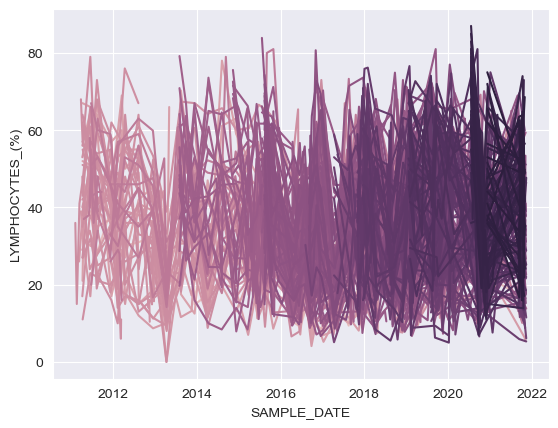

In [62]:
# viz lymphocytes of all monkeys over the totality of the study to date
sns.lineplot(data = for_bio_df, x = "SAMPLE_DATE", y = "LYMPHOCYTES_(%)", hue='ID', legend=False);

# 1.) CatBoost forecasting
Looks like true forcasting may be harder with this method
The platform is also pretty shotty/

## Skforecast quickstart

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
print('setup complete')

setup complete


### Viz and split

Train dates : 2017-11-02 00:00:00 --- 2020-01-29 00:00:00  (n=13)
Test dates  : 2020-09-29 00:00:00 --- 2021-10-07 00:00:00  (n=5)


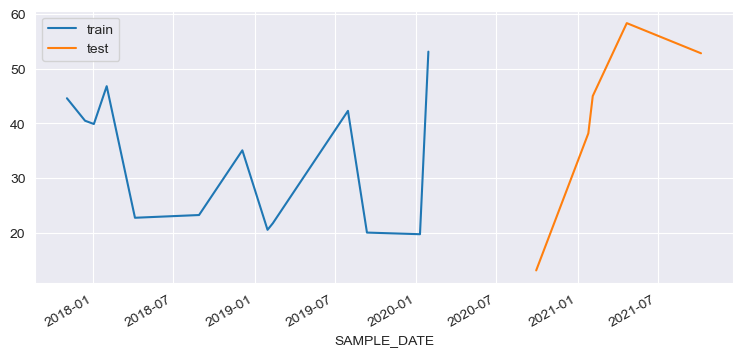

In [98]:
# need to set sample date as index
#single_bio_df = single_bio_df.set_index('SAMPLE_DATE')

#specify end of the train: trying to get close to a 70/30 split
end_train = '2020-02-01 00:00:00'

# Determine the train/test timeframes and samples
print(f"Train dates : {single_bio_df.index.min()} --- {single_bio_df.loc[:end_train].index.max()}  (n={len(single_bio_df.loc[:end_train])})")
print(f"Test dates  : {single_bio_df.loc[end_train:].index.min()} --- {single_bio_df.index.max()}  (n={len(single_bio_df.loc[end_train:])})")

# Plot the test and train, will do all if a column isnt specified
fig, ax=plt.subplots(figsize=(9, 4))
single_bio_df['LYMPHOCYTES_(%)'].loc[:end_train].plot(ax=ax, label='train')
single_bio_df['LYMPHOCYTES_(%)'].loc[end_train:].plot(ax=ax, label='test')
ax.legend();

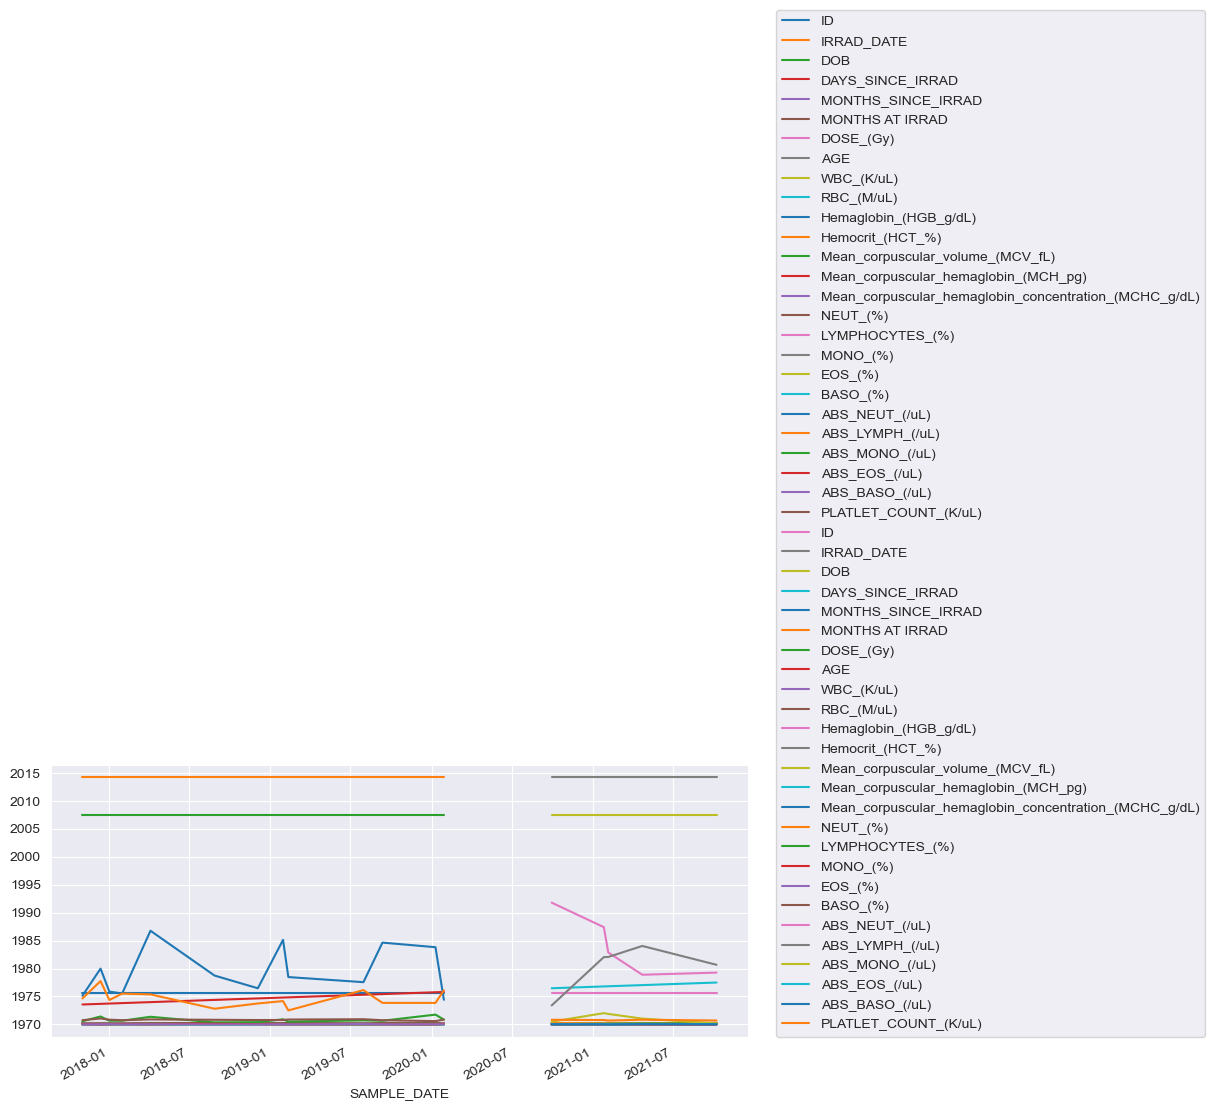

In [88]:
# Plot the test and train, will do all if a column isnt specified
### See if there's a better way to viz - lots of variables and the colors switch
fig, ax=plt.subplots(figsize=(9, 4))
single_bio_df.loc[:end_train].plot(ax=ax, label='train')
single_bio_df.loc[end_train:].plot(ax=ax, label='test');
ax.legend(loc=(1.04, 0));

### Train Forecaster

In [109]:
# regress the lymphocytes - has to be a series
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 1
             )

forecaster.fit(y=single_bio_df['LYMPHOCYTES_(%)'].loc[:end_train])
forecaster

`y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
`y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 12] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-14 15:51:36 
Last fit date: 2023-02-14 15:51:36 
Skforecast version: 0.6.0 
Python version: 3.10.9 

### Predictions

In [118]:
# predict the last of the data
predictions = forecaster.predict(steps=len(single_bio_df['LYMPHOCYTES_(%)'].loc[end_train:]))
predictions.head(3)

`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


1    27.270
2    32.707
3    29.508
Name: pred, dtype: float64

In [119]:
# predict 30 steps from the end of the train
pred30 = forecaster.predict(steps=30)
pred30.tail(3)

`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


28    25.253
29    32.707
30    29.508
Name: pred, dtype: float64

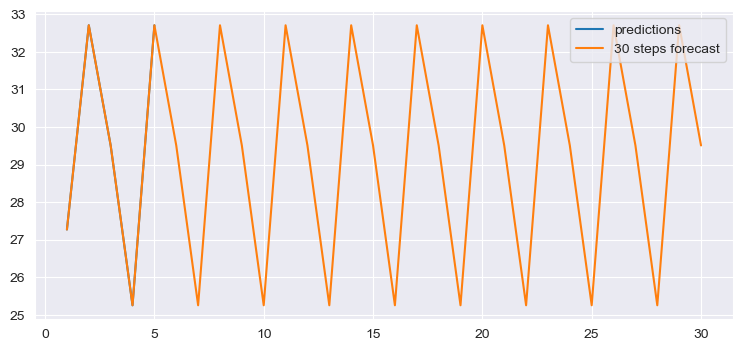

In [120]:
fig, ax=plt.subplots(figsize=(9, 4))
#single_bio_df['LYMPHOCYTES_(%)'].loc[:end_train].plot(ax=ax, label='train')
#single_bio_df['LYMPHOCYTES_(%)'].loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
pred30.plot(ax=ax, label='30 steps forecast')
ax.legend();


### Unsure why the x-axis isnt time, either way the predictions are off by a bit, it was a hard one

In [105]:
# calculate mse
error_mse = mean_squared_error(
                y_true = single_bio_df['LYMPHOCYTES_(%)'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 392.79457420000097


## CatBoost Impliment

### Train forcaster w/ catboost regressor

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 1
             )

forecaster

### Predictions of end data and 30 steps from end of train

In [130]:
# Use catboost regressor to predict the end of the data 
cat_predictions = forecaster.predict(steps=len(single_bio_df['LYMPHOCYTES_(%)'].loc[end_train:]))
cat_predictions.head(3)

`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


1    27.270
2    32.707
3    29.508
Name: pred, dtype: float64

In [131]:
# Use catboost regressor to predict 30 steps from the end of the train
cat_pred30 = forecaster.predict(steps=30)
cat_pred30.tail(3)

`last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.


28    25.253
29    32.707
30    29.508
Name: pred, dtype: float64

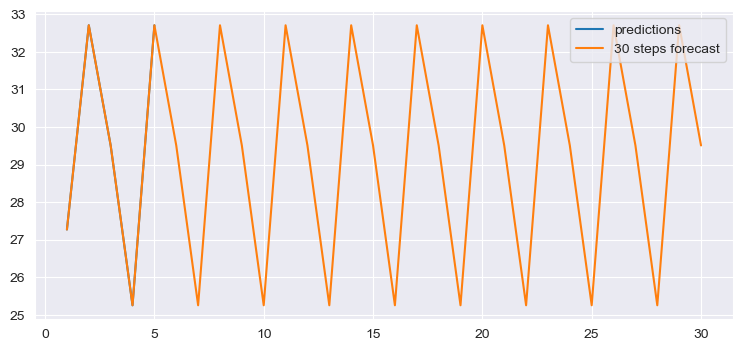

In [132]:
# Plot the predictions
fig, ax=plt.subplots(figsize=(9, 4))
#single_bio_df['LYMPHOCYTES_(%)'].loc[:end_train].plot(ax=ax, label='train')
#single_bio_df['LYMPHOCYTES_(%)'].loc[end_train:].plot(ax=ax, label='test')
cat_predictions.plot(ax=ax, label='predictions')
cat_pred30.plot(ax=ax, label='30 steps forecast')
ax.legend();


### Unsure why the x-axis isnt time, either way the predictions are off by a bit, it was a hard one

# 2.) ARIMA forecasting

Using the statsmodels ARIMA https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

In [19]:
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
print('Complete')

Complete


In [21]:
single_bio_df.head()

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


In [28]:
arima_data = single_bio_df[['SAMPLE_DATE','LYMPHOCYTES_(%)']].copy()
arima_data.head()

,SAMPLE_DATE,LYMPHOCYTES_(%)
33,2017-11-02,44.6
34,2017-12-13,40.5
35,2018-01-02,39.9
36,2018-01-31,46.8
37,2018-04-05,22.8


In [25]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [32]:
#Fits the ARIMA model - in the current form, it gives a freq error
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = arima_data['LYMPHOCYTES_(%)']
model = ARIMA(arima_data['LYMPHOCYTES_(%)'], 
              order=(5, 1, 0), 
              dates=arima_data['SAMPLE_DATE'], 
              freq='MS'
             )
model_fit = model.fit()
print(model_fit.summary())

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


ValueError: The given frequency argument could not be matched to the given index.

In [28]:
data.head()


33    44.6
34    40.5
35    39.9
36    46.8
37    22.8
Name: LYMPHOCYTES_(%), dtype: float64

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2020-02-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

# 3.) Prophet forcasting

# Conclusions